In [1]:
# Main libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split as tts, cross_val_score as cv, GridSearchCV
from sklearn.linear_model import LinearRegression as lreg, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape, r2_score as r2
import joblib as jbl
import gradio as gr

In [2]:
# Importing the dataset

file = r'C:\Users\domingosdeeularia...car_prices.csv'
df = pd.read_csv(file)
df.head()

,year,make,transmission,condition,odometer,color,interior,mmr,sellingprice
0,2015,Kia,automatic,5.0,16639.0,white,black,20500.0,21500.0
1,2015,Kia,automatic,5.0,9393.0,white,beige,20800.0,21500.0
2,2014,BMW,automatic,45.0,1331.0,gray,black,31900.0,30000.0
3,2015,Volvo,automatic,41.0,14282.0,white,black,27500.0,27750.0
4,2014,BMW,automatic,43.0,2641.0,gray,black,66000.0,67000.0


In [3]:
# Dropping missing values

df.dropna(inplace = True)

In [4]:
# TRansforming the 'make' columns

df['make'] = df.make.str.upper()
df['make'] = df.make.str.split(' |-', expand = True)[0]

In [5]:
# Passing the categorical columns except 'make' to title style

col_cat_diff_make = df.dtypes[(df.dtypes == object) & (df.dtypes.index != 'make')].index

df[col_cat_diff_make] = df[col_cat_diff_make].map(lambda cell: cell.title())

In [6]:
# Transforming the year column

df ['year'] = 2024 - df.year

df.rename(columns = {'year': 'age'}, inplace = True)

In [7]:
# Lists of numerical and Categorical Atributtes

col_num = list(df.dtypes[df.dtypes != object].index)
col_cat = list(df.dtypes[df.dtypes == object].index)

In [8]:
# Pipeline for numerical attributes

pipe_num = Pipeline(steps = [('inputer', SimpleImputer(strategy = 'mean'))])

In [9]:
# Pipeline for categorical attributes

pipe_cat = Pipeline(steps = [
    ('imputer', SimpleImputer(missing_values = '—', strategy = 'most_frequent'))])

In [10]:
# Composing the whole pipelines

preprocessor_ = ColumnTransformer(transformers = [
    ('num', pipe_num, col_num), 
    ('cat', pipe_cat, col_cat)])

prep_pipeline = Pipeline( steps = [('preprocessor', preprocessor_)])

In [11]:
# Fitting the pipeline in the dataframe

prep_transf = prep_pipeline.fit_transform(df)

In [12]:
# Columns after transformation arrangement

cols_prep = [i[5:] for i in preprocessor_.get_feature_names_out()]

In [13]:
# Transformed dataframe

df_prep = pd.DataFrame(prep_transf, columns = cols_prep)


# Ordering as in the original dataframe

df_prep = df_prep[df.columns]

In [14]:
# Types after transformation

df_prep.dtypes.value_counts()

object    9
Name: count, dtype: int64

In [15]:
# Conversion for numeric columns

for col in col_num:
    df_prep[col] = df_prep[col].astype(float)

In [16]:
# Types after transformation after conversion

df_prep.dtypes.value_counts()

float64    5
object     4
Name: count, dtype: int64

In [17]:
# First rows of the preprocessing dataframe

df_prep.head()

,age,make,transmission,condition,odometer,color,interior,mmr,sellingprice
0,9.0,KIA,Automatic,5.0,16639.0,White,Black,20500.0,21500.0
1,9.0,KIA,Automatic,5.0,9393.0,White,Beige,20800.0,21500.0
2,10.0,BMW,Automatic,45.0,1331.0,Gray,Black,31900.0,30000.0
3,9.0,VOLVO,Automatic,41.0,14282.0,White,Black,27500.0,27750.0
4,10.0,BMW,Automatic,43.0,2641.0,Gray,Black,66000.0,67000.0


In [18]:
# Correlation on numerical attributes

df_corr = df_prep[col_num].corr()
df_corr

,age,condition,odometer,mmr,sellingprice
age,1.000000,-0.336624,0.772495,-0.588387,-0.578738
condition,-0.336624,1.000000,-0.315425,0.277735,0.318697
odometer,0.772495,-0.315425,1.000000,-0.582398,-0.577192
mmr,-0.588387,0.277735,-0.582398,1.000000,0.983587
sellingprice,-0.578738,0.318697,-0.577192,0.983587,1.000000


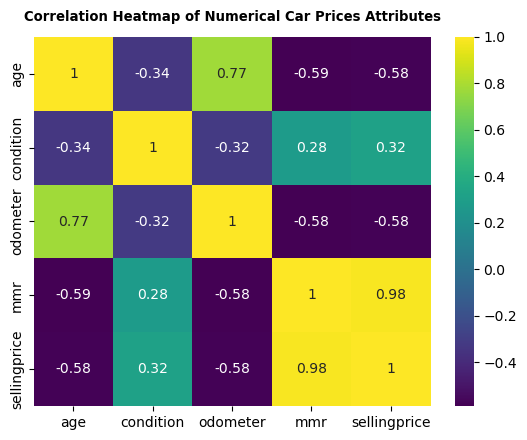

In [19]:
# Plotting the Heatmap

plt.title('Correlation Heatmap of Numerical Car Prices Attributes', y = 1.02, fontsize = 9.5, fontweight = 'bold')
sns.heatmap(df_corr, annot = True, cmap = 'viridis')
plt.show()

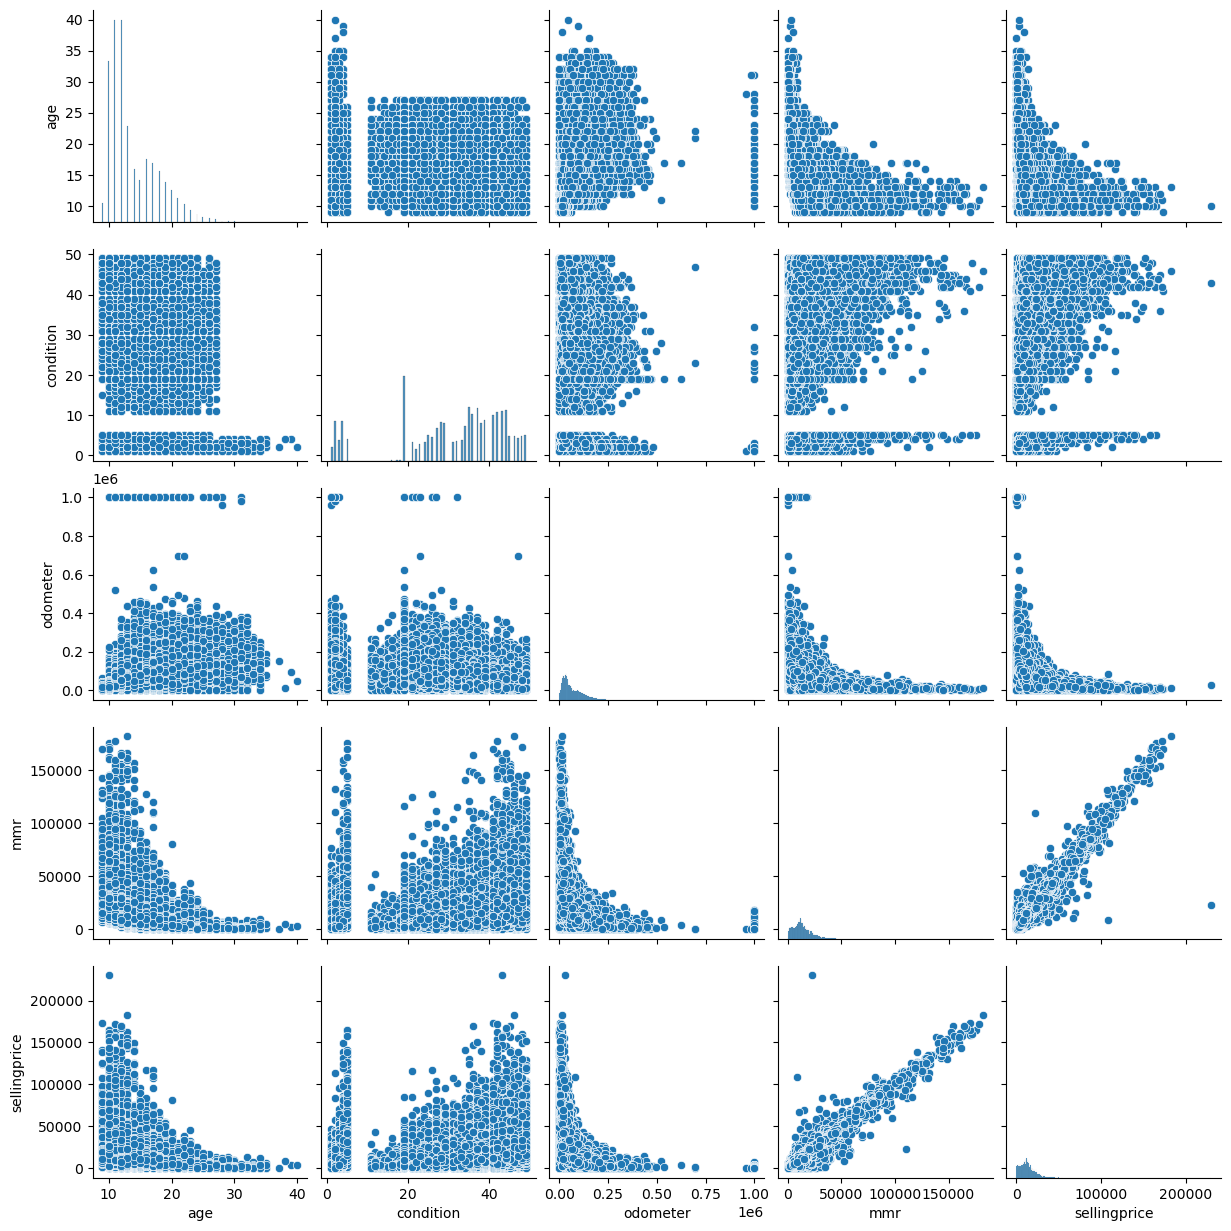

In [20]:
# Displaying the pairplot

sns.pairplot(df_prep)
plt.show()

In [21]:
# Splitting the dataframe into train and test sets

y, X = df_prep.sellingprice, df_prep.drop(columns = ['sellingprice'])

X = pd.get_dummies(X, drop_first = True)

X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 7)

In [22]:
# Looping through the candidate models and providing results

candidate_models = {'OLS': lreg(), 'Lasso': Lasso(), 'Ridge': Ridge(), 'ElasticNet': ElasticNet()}

param_grid = {'regressor__alpha': [0.1, 1, 10],
                      'regressor__l1_ratio': [0.1, 0.5, 0.9]}
dict_scores =  {}


for model_name, model_instance in candidate_models.items():
    
    model_pipeline = Pipeline(steps = [
        ('scaler', RobustScaler()),
        ('feature_selection', RFE(model_instance)),
        ('regressor', model_instance)
    ])

    
    if model_name == 'OLS':

        scores = cv(model_pipeline, X_train, y_train, scoring = 'neg_mean_squared_error')
        dict_scores[model_name] =  scores.mean()

    elif model_name == 'ElasticNet':

        gridsearch_cv = GridSearchCV(model_pipeline, param_grid = param_grid, scoring = 'neg_mean_squared_error')
        gridsearch_cv.fit(X_train, y_train)
        best_model = gridsearch_cv.best_estimator_
        scores = cv(best_model, X_train, y_train, scoring = 'neg_mean_squared_error')
        dict_scores[model_name] =  scores.mean()

    else:
        gridsearch_cv = GridSearchCV(model_pipeline, param_grid = {'regressor__alpha': param_grid['regressor__alpha']}, 
                                     scoring = 'neg_mean_squared_error')
        gridsearch_cv.fit(X_train, y_train)
        best_model = gridsearch_cv.best_estimator_
        scores = cv(best_model, X_train, y_train, scoring = 'neg_mean_squared_error')
        dict_scores[model_name] =  scores.mean()
   
df_scores = pd.DataFrame(list(dict_scores.items()), columns=['Model', 'Mean Score'])
df_scores

,Model,Mean Score
0,OLS,-2.876362e+06
1,Lasso,-2.872628e+06
2,Ridge,-2.875940e+06
3,ElasticNet,-2.900467e+06


In [23]:
# Model name with best performance and its instance

best_model_name = df_scores[df_scores['Mean Score'] == df_scores['Mean Score'].max()].Model.values[0]
best_model_instance = candidate_models[best_model_name]

In [24]:
# Passing the best model pipeline

best_model_pipeline = Pipeline(steps = [
        ('scaler', RobustScaler()),
        ('feature_selection', RFE(best_model_instance)),
        ('regressor', best_model_instance)
    ])

In [25]:
# Fittng the best model and making predictions on test set

y_pred = best_model_pipeline.fit(X_train, y_train).predict(X_test)
y_pred

array([12833.61856965,   975.74404167, 13098.89912223, ...,
       13973.4437568 ,  1290.52478571,  5149.87977519])

In [73]:
# Overall evaluation metrics

print('R2:', round(r2(y_test, y_pred), 3), 
      '\nMSE:', round(mse(y_test, y_pred), 2),
      '\nRMSE:', round(mse(y_test, y_pred, squared=False),2), 
      '\nMAE:', round(mae(y_test, y_pred), 2),
      '\nMAPE (%):', round(mape(y_test, y_pred) * 100,2))

R2: 0.972 
MSE: 2615844.11 
RMSE: 1617.36 
MAE: 1039.12 
MAPE (%): 15.2


                 ________  ________   _______   ______ 
                 /_  __/ / / / ____/  / ____/ | / / __ \
                  / / / /_/ / __/    / __/ /  |/ / / / /
                 / / / __  / /___   / /___/ /|  / /_/ / 
                /_/ /_/ /_/_____/  /_____/_/ |_/_____/  
